In [ ]:
# Import Libraries and Load Dataset

In [1]:
import os
from datasets import load_dataset, ClassLabel, Sequence
from transformers import AutoTokenizer

# --- Configuration Parameters ---
CORPUS_NAME = "ncbi_disease"
FOUNDATION_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
PROCESSED_DATA_DIRECTORY = "corpus_data/prepared_ncbi_disease"
TAG_COLUMN = "ner_tags"

# --- 1. Import Corpus ---
print(f"Importing corpus: {CORPUS_NAME}...")
try:
    corpus_collection = load_dataset(CORPUS_NAME)
except Exception as err:
     print(f"Trying with trust_remote_code=True due to error: {err}")
     corpus_collection = load_dataset(CORPUS_NAME, trust_remote_code=True)

print("Corpus imported:")
print(corpus_collection)

Importing corpus: ncbi_disease...


README.md:   0%|          | 0.00/9.70k [00:00<?, ?B/s]

C:\Users\TTB\fresh_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TTB\.cache\huggingface\hub\datasets--ncbi_disease. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ncbi_disease.py:   0%|          | 0.00/5.83k [00:00<?, ?B/s]

Trying with trust_remote_code=True due to error: The repository for ncbi_disease contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ncbi_disease.
Please pass the argument `trust_remote_code=True` to allow custom code to be run.


Generating train split:   0%|          | 0/5433 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/924 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

Corpus imported:
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})


In [ ]:
# Examine Dataset Structure

In [2]:
# --- 2. Analyze Corpus Structure ---
print("\nExamining corpus structure:")
print(corpus_collection["train"].features)

print("\nInspecting first training sample:")
sample_entry = corpus_collection["train"][0]
print(sample_entry)

# Extract category information and create mappings
category_list = corpus_collection["train"].features[TAG_COLUMN].feature.names
category_to_index = {category: i for i, category in enumerate(category_list)}
index_to_category = {i: category for i, category in enumerate(category_list)}
category_count = len(category_list)

print(f"\nCategories: {category_list}")
print(f"Category to index mapping: {category_to_index}")
print(f"Total categories: {category_count}")


Examining corpus structure:
{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)}

Inspecting first training sample:
{'id': '0', 'tokens': ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}

Categories: ['O', 'B-Disease', 'I-Disease']
Category to index mapping: {'O': 0, 'B-Disease': 1, 'I-Disease': 2}
Total categories: 3


In [ ]:
# 3 Initialize Tokenizer

In [3]:
# --- 3. Initialize Tokenizer ---
print(f"\nInitializing tokenizer for model: {FOUNDATION_MODEL}...")
token_processor = AutoTokenizer.from_pretrained(FOUNDATION_MODEL)
print("Tokenizer loaded.")


Initializing tokenizer for model: emilyalsentzer/Bio_ClinicalBERT...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

C:\Users\TTB\fresh_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TTB\.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Tokenizer loaded.


In [ ]:
# 4 Define Tokenization and Label Alignment Function

In [4]:
# --- 4. Tokenization and Label Alignment Function ---
def process_and_align_labels(examples, annotate_all_tokens=False):
    """
    Convert text to tokens and align NER labels with tokenized output.
    examples: A batch of examples from the corpus.
    annotate_all_tokens: If True, assign label to all tokens of a word;
                      If False, assign label only to the first token.
    """
    # Process the 'tokens' field. Since input is already tokenized,
    # set is_split_into_words=True.
    processed_inputs = token_processor(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
    )

    annotations = []
    for i, tag_sequence in enumerate(examples[TAG_COLUMN]):
        word_indices = processed_inputs.word_ids(batch_index=i)
        last_word_idx = None
        tag_indices = []
        for word_idx in word_indices:
            # Special tokens have a word id that is None.
            # We set the label to -100 so they are automatically ignored in the loss function.
            if word_idx is None:
                tag_indices.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != last_word_idx:
                tag_indices.append(tag_sequence[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100,
            # depending on the annotate_all_tokens flag.
            else:
                tag_indices.append(tag_sequence[word_idx] if annotate_all_tokens else -100)
            last_word_idx = word_idx

        annotations.append(tag_indices)

    processed_inputs["labels"] = annotations
    return processed_inputs

print("\nApplying tokenization and label alignment...")
# Process all corpus partitions
# batched=True processes multiple examples at once for efficiency
processed_corpus = corpus_collection.map(process_and_align_labels, batched=True)

print("\nExample of processed input and aligned labels:")
print("Tokens:", token_processor.convert_ids_to_tokens(processed_corpus["train"][0]['input_ids']))
print("Labels:", processed_corpus["train"][0]['labels'])


Applying tokenization and label alignment...


Map:   0%|          | 0/5433 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]


Example of processed input and aligned labels:
Tokens: ['[CLS]', 'identification', 'of', 'a', '##p', '##c', '##2', ',', 'a', 'ho', '##mo', '##logue', 'of', 'the', 'ad', '##eno', '##mat', '##ous', 'p', '##oly', '##po', '##sis', 'co', '##li', 't', '##umour', 'suppress', '##or', '.', '[SEP]']
Labels: [-100, 0, 0, 0, -100, -100, -100, 0, 0, 0, -100, -100, 0, 0, 1, -100, -100, -100, 2, -100, -100, -100, 2, -100, 2, -100, 0, -100, 0, -100]


In [ ]:
# 5 Save Processed Dataset

In [5]:
# --- 5. Store Processed Corpus (Recommended) ---
print(f"\nSaving processed corpus to {PROCESSED_DATA_DIRECTORY}...")
os.makedirs(PROCESSED_DATA_DIRECTORY, exist_ok=True)
processed_corpus.save_to_disk(PROCESSED_DATA_DIRECTORY)
# Also save category mappings
import json
with open(os.path.join(PROCESSED_DATA_DIRECTORY, "category_mappings.json"), 'w') as f:
    json.dump({"category_list": category_list, "category_to_index": category_to_index, "index_to_category": index_to_category}, f)

print("\nCorpus Preparation Completed.")


Saving processed corpus to corpus_data/prepared_ncbi_disease...


Saving the dataset (0/1 shards):   0%|          | 0/5433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/924 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/941 [00:00<?, ? examples/s]


Corpus Preparation Completed.


In [ ]:
# 6 Knowledge Base Preparation - Install FAISS and Import Libraries

In [3]:
import sys
!{sys.executable} -m pip install faiss-cpu sentence-transformers torch


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\TTB\fresh_env\Scripts\python.exe -m pip install --upgrade pip


In [2]:
# Cell 6: Knowledge Base Preparation - Simplified No-Dependency Version
!pip install faiss-cpu
!pip install transformers torch scikit-learn

import os
import faiss
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import normalize
import pickle

# --- Configuration ---
scholarly_texts = [
    "COVID-19, caused by SARS-CoV-2, is a respiratory illness. Common symptoms include fever, cough, and shortness of breath. Remdesivir has shown some efficacy in hospitalized patients.",
    "Diabetes mellitus type 2 is a metabolic disorder characterized by high blood sugar. Lifestyle changes and metformin are common first-line treatments.",
    "Metformin works by decreasing glucose production by the liver and increasing the insulin sensitivity of body tissues.",
    "Alzheimer's disease is a progressive neurodegenerative disorder. Early symptoms often include memory loss. There is no cure, but treatments can manage symptoms.",
    "Clinical trials are investigating new therapies for Alzheimer's targeting amyloid plaques.",
    "Fever is an elevation in body temperature, often a sign of infection. Acetaminophen or ibuprofen can be used to reduce fever.",
]

SEGMENT_SIZE = 100  # Words per segment
SEGMENT_OVERLAP = 20  # Words overlapping between segments
KNOWLEDGE_BASE_DIR = "kb_data"
VECTOR_INDEX_PATH = os.path.join(KNOWLEDGE_BASE_DIR, "scholarly_faiss.index")
TEXT_SEGMENTS_PATH = os.path.join(KNOWLEDGE_BASE_DIR, "scholarly_segments.pkl")

# --- 1. Create text segments ---
def create_segments(text_collection, segment_size, segment_overlap):
    all_segments = []
    for text in text_collection:
        words = text.split()
        for i in range(0, len(words), segment_size - segment_overlap):
            segment = words[i : i + segment_size]
            if segment:  # Avoid empty segments
                all_segments.append(" ".join(segment))
    return all_segments

print("Segmenting documents...")
text_segments = create_segments(scholarly_texts, SEGMENT_SIZE, SEGMENT_OVERLAP)
print(f"Created {len(text_segments)} segments.")
print("Example segment:", text_segments[0])

# --- 2. Define custom embedding function using BERT ---
def mean_pooling(model_output, attention_mask):
    # Mean Pooling - Take attention mask into account for correct averaging
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
print("\nLoading BERT model for embeddings...")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# --- 3. Create embeddings ---
print("\nEmbedding text segments...")
# Tokenize sentences
encoded_input = tokenizer(text_segments, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = normalize(sentence_embeddings.numpy(), norm='l2', axis=1)
vector_embeddings = np.array(sentence_embeddings).astype('float32')

print(f"Embeddings shape: {vector_embeddings.shape}")

# --- 4. Build vector index ---
print("\nBuilding vector index...")
embedding_dim = vector_embeddings.shape[1]
vector_index = faiss.IndexFlatL2(embedding_dim)
vector_index.add(vector_embeddings)
print(f"Vector index built. Total vectors in index: {vector_index.ntotal}")

# --- 5. Save index and text segments ---
print(f"\nSaving vector index to {VECTOR_INDEX_PATH}")
os.makedirs(KNOWLEDGE_BASE_DIR, exist_ok=True)
faiss.write_index(vector_index, VECTOR_INDEX_PATH)

print(f"Saving text segments to {TEXT_SEGMENTS_PATH}")
with open(TEXT_SEGMENTS_PATH, 'wb') as f:
    pickle.dump(text_segments, f)

print("\nKnowledge Base Preparation Completed.")

Segmenting documents...
Created 6 segments.
Example segment: COVID-19, caused by SARS-CoV-2, is a respiratory illness. Common symptoms include fever, cough, and shortness of breath. Remdesivir has shown some efficacy in hospitalized patients.

Loading BERT model for embeddings...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\TTB\fresh_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TTB\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Embedding text segments...
Embeddings shape: (6, 768)

Building vector index...
Vector index built. Total vectors in index: 6

Saving vector index to kb_data\scholarly_faiss.index
Saving text segments to kb_data\scholarly_segments.pkl

Knowledge Base Preparation Completed.


In [3]:
# 7 Complete the Knowledge Base Setup with Query Demonstration

In [4]:
# Cell 7: Demonstrate Knowledge Base Retrieval

import os
import faiss
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import normalize
import pickle

# --- Load Saved Resources ---
KNOWLEDGE_BASE_DIR = "kb_data"
VECTOR_INDEX_PATH = os.path.join(KNOWLEDGE_BASE_DIR, "scholarly_faiss.index")
TEXT_SEGMENTS_PATH = os.path.join(KNOWLEDGE_BASE_DIR, "scholarly_segments.pkl")

# Check if files exist
print("Loading knowledge base resources...")
if not os.path.exists(VECTOR_INDEX_PATH):
    raise FileNotFoundError(f"Vector index not found at {VECTOR_INDEX_PATH}. Please run the previous cell first.")
if not os.path.exists(TEXT_SEGMENTS_PATH):
    raise FileNotFoundError(f"Text segments not found at {TEXT_SEGMENTS_PATH}. Please run the previous cell first.")

# Load vector index
vector_index = faiss.read_index(VECTOR_INDEX_PATH)
print(f"Vector index loaded. Contains {vector_index.ntotal} vectors of dimension {vector_index.d}.")

# Load text segments
with open(TEXT_SEGMENTS_PATH, 'rb') as f:
    text_segments = pickle.load(f)
print(f"Loaded {len(text_segments)} text segments.")

# --- Define Functions for Embedding and Retrieval ---
def mean_pooling(model_output, attention_mask):
    """Perform mean pooling on token embeddings with attention mask."""
    token_embeddings = model_output[0]  # First element contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def embed_query(query_text, tokenizer, model):
    """Convert a text query to an embedding vector."""
    # Tokenize the query
    encoded_input = tokenizer([query_text], padding=True, truncation=True, max_length=128, return_tensors='pt')
    
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Perform pooling and normalization
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    embeddings = normalize(embeddings.numpy(), norm='l2', axis=1)
    
    return embeddings.astype('float32')

def retrieve_relevant_passages(query_text, top_k=2):
    """Retrieve the most relevant passages for a given query."""
    # Load model if not already loaded
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')
    
    # Embed the query
    query_embedding = embed_query(query_text, tokenizer, model)
    
    # Search the index
    distances, indices = vector_index.search(query_embedding, top_k)
    
    # Collect results
    results = []
    for i, (idx, distance) in enumerate(zip(indices[0], distances[0])):
        if idx < len(text_segments):  # Ensure index is valid
            results.append({
                "rank": i + 1,
                "text": text_segments[idx],
                "distance": float(distance)
            })
    
    return results

# --- Demonstrate Retrieval with Example Queries ---
print("\n--- Knowledge Base Query Demonstration ---")

example_queries = [
    "What is COVID-19 and what are its symptoms?",
    "How does metformin work for treating diabetes?",
    "What treatments are being researched for Alzheimer's disease?"
]

for i, query in enumerate(example_queries, 1):
    print(f"\nExample Query {i}: '{query}'")
    results = retrieve_relevant_passages(query, top_k=2)
    
    print(f"Top {len(results)} relevant passages:")
    for result in results:
        print(f"Rank {result['rank']} (distance: {result['distance']:.4f}):")
        print(f"{result['text']}")
        print()

print("\nKnowledge base retrieval demonstration completed.")

# --- Function for Future Use in RAG Applications ---
def get_context_for_query(query, max_passages=2):
    """Retrieve context for a query - to be used in RAG applications."""
    passages = retrieve_relevant_passages(query, top_k=max_passages)
    if not passages:
        return "No relevant information found."
    
    context = "\n\n".join([p["text"] for p in passages])
    return context

# Example of how this would be used in a RAG application
print("\n--- Example RAG Context Retrieval ---")
sample_query = "What medications help with fever?"
retrieved_context = get_context_for_query(sample_query)
print(f"Query: {sample_query}")
print("\nRetrieved Context:")
print(retrieved_context)

Loading knowledge base resources...
Vector index loaded. Contains 6 vectors of dimension 768.
Loaded 6 text segments.

--- Knowledge Base Query Demonstration ---

Example Query 1: 'What is COVID-19 and what are its symptoms?'
Top 2 relevant passages:
Rank 1 (distance: 0.6909):
COVID-19, caused by SARS-CoV-2, is a respiratory illness. Common symptoms include fever, cough, and shortness of breath. Remdesivir has shown some efficacy in hospitalized patients.

Rank 2 (distance: 0.8430):
Alzheimer's disease is a progressive neurodegenerative disorder. Early symptoms often include memory loss. There is no cure, but treatments can manage symptoms.


Example Query 2: 'How does metformin work for treating diabetes?'
Top 2 relevant passages:
Rank 1 (distance: 0.5077):
Clinical trials are investigating new therapies for Alzheimer's targeting amyloid plaques.

Rank 2 (distance: 0.5180):
Metformin works by decreasing glucose production by the liver and increasing the insulin sensitivity of body tis

In [ ]:
# Cell 8: Install Required Libraries and Prepare for NER Model Fine-tuning

In [9]:
import sys
!{sys.executable} -m pip install datasets transformers torch seqeval tf-keras

     ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
     ---- ----------------------------------- 0.2/1.7 MB 5.3 MB/s eta 0:00:01
     ---------------------------- ----------- 1.2/1.7 MB 15.5 MB/s eta 0:00:01
     ---------------------------------------- 1.7/1.7 MB 15.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\TTB\fresh_env\Scripts\python.exe -m pip install --upgrade pip


In [10]:
# Cell 8: Prepare for NER Model Fine-tuning (PyTorch-only approach)

# # First, install the backwards-compatible tf-keras to resolve dependency issues
# !pip install tf-keras
# !pip install seqeval
# !pip install datasets torch

import os
import json
import torch
import numpy as np
from datasets import load_dataset
import pickle
from seqeval.metrics import classification_report

# --- Configuration ---
CORPUS_NAME = "ncbi_disease"
PREPARED_CORPUS_DIR = "corpus_data/prepared_ncbi_disease"
PRETRAINED_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
OUTPUT_MODEL_DIR = "models/biobert_disease_entity_recognizer"
CATEGORY_MAPPINGS_PATH = os.path.join(PREPARED_CORPUS_DIR, "category_mappings.json")

OPTIMIZER_RATE = 2e-5
TRAINING_BATCH = 16
EPOCHS = 3
WEIGHT_DECAY_FACTOR = 0.01

# --- 1. Check for prepared data, otherwise load raw data ---
print(f"Checking for prepared corpus at {PREPARED_CORPUS_DIR}...")
if not os.path.exists(PREPARED_CORPUS_DIR):
    print(f"Prepared corpus not found. Loading raw data instead...")
    
    # Load the raw dataset
    raw_dataset = load_dataset(CORPUS_NAME, trust_remote_code=True)
    print(f"Raw dataset loaded: {raw_dataset}")
    
    # Extract and save a sample for later use
    train_samples = raw_dataset["train"][:5]  # First 5 examples
    val_samples = raw_dataset["validation"][:3]
    test_samples = raw_dataset["test"][:3]
    
    # Create samples directory
    samples_dir = os.path.join("corpus_data", "samples")
    os.makedirs(samples_dir, exist_ok=True)
    
    # Save samples for future reference
    with open(os.path.join(samples_dir, "ncbi_disease_samples.pkl"), "wb") as f:
        pickle.dump({
            "train": train_samples,
            "validation": val_samples,
            "test": test_samples
        }, f)
    
    # Extract label information
    tag_column = "ner_tags"
    feature = raw_dataset["train"].features[tag_column]
    if hasattr(feature, "feature") and hasattr(feature.feature, "names"):
        category_list = feature.feature.names
        category_to_index = {category: i for i, category in enumerate(category_list)}
        index_to_category = {i: category for i, category in enumerate(category_list)}
        num_categories = len(category_list)
        
        print(f"\nCategories: {category_list}")
        print(f"Category to index mapping: {category_to_index}")
        print(f"Total categories: {num_categories}")
        
        # Save category mappings
        os.makedirs(PREPARED_CORPUS_DIR, exist_ok=True)
        with open(CATEGORY_MAPPINGS_PATH, 'w') as f:
            json.dump({
                "category_list": category_list,
                "category_to_index": category_to_index,
                "index_to_category": index_to_category
            }, f)
            
        print(f"Category mappings saved to {CATEGORY_MAPPINGS_PATH}")
    else:
        print("Could not extract category information from dataset.")
        category_list = ['O', 'B-Disease', 'I-Disease']  # Default for NCBI Disease
        category_to_index = {category: i for i, category in enumerate(category_list)}
        index_to_category = {i: category for i, category in enumerate(category_list)}
        num_categories = len(category_list)
    
    # We'll use the raw data in the next cell instead of processed data
    print("Raw data will be used in the next cell for training.")
    
else:
    # Load category mappings if the prepared corpus directory exists
    print(f"Loading category mappings from {CATEGORY_MAPPINGS_PATH}...")
    try:
        with open(CATEGORY_MAPPINGS_PATH, 'r') as f:
            category_mappings = json.load(f)
        
        category_list = category_mappings["category_list"]
        category_to_index = category_mappings["category_to_index"]
        index_to_category = {int(k): v for k, v in category_mappings["index_to_category"].items()}
        num_categories = len(category_list)
        
        print(f"Found {num_categories} categories: {category_list}")
    except Exception as e:
        print(f"Error loading category mappings: {e}")
        # Fallback to default mapping
        category_list = ['O', 'B-Disease', 'I-Disease']
        category_to_index = {category: i for i, category in enumerate(category_list)}
        index_to_category = {i: category for i, category in enumerate(category_list)}
        num_categories = len(category_list)
        print(f"Using default categories: {category_list}")

# --- 2. Define custom metric calculation function ---
def convert_to_bio_tags(raw_example, id_to_label_map):
    """Convert raw example with ner_tags to BIO format tags"""
    entities = []
    bio_tags = []
    for token, tag_id in zip(raw_example["tokens"], raw_example["ner_tags"]):
        tag = id_to_label_map.get(tag_id, 'O')
        bio_tags.append(tag)
    return bio_tags

def calculate_bio_metrics(pred_entities, gold_entities):
    """Calculate precision, recall, F1 for BIO-tagged entities"""
    # Use seqeval library which expects lists of tags
    try:
        report = classification_report([gold_entities], [pred_entities], output_dict=True, zero_division=0)
        weighted_avg = report.get("weighted avg", {})
        return {
            "precision": weighted_avg.get("precision", 0.0),
            "recall": weighted_avg.get("recall", 0.0),
            "f1": weighted_avg.get("f1", 0.0)
        }
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}

# --- 3. Create a simple PyTorch NER model for demonstration ---
class SimpleNERModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleNERModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.hidden2tag = torch.nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        return tag_space

# --- 4. Check GPU availability ---
compute_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {compute_device}")
if compute_device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Memory cached: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

# --- 5. Create a toy vocabulary for demonstration ---
print("\nCreating a demonstration vocabulary...")
# This will be replaced by the actual tokenizer vocabulary in the training cell
VOCAB_SIZE = 5000
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = num_categories

# Create a small demo model to show it works
demo_model = SimpleNERModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(f"Demo model created with {sum(p.numel() for p in demo_model.parameters()):,} parameters")

# Create output directories
model_output_dir = os.path.join("models", "biobert_disease_entity_recognizer")
os.makedirs(model_output_dir, exist_ok=True)

print("\nPreparing for BIO tagging NER model training...")

# --- 6. Display example from the dataset for reference ---
print("\nExample of BIO tag format:")
print("Token\t\tBIO Tag")
print("-" * 30)

# Load a sample if available
try:
    with open(os.path.join("corpus_data", "samples", "ncbi_disease_samples.pkl"), "rb") as f:
        samples = pickle.load(f)
    example = samples["train"][0]
except:
    # If samples aren't available, try to load from the raw dataset
    try:
        example = load_dataset(CORPUS_NAME, trust_remote_code=True)["train"][0]
    except:
        print("Could not load an example. Using a dummy example instead.")
        example = {
            "tokens": ["Identification", "of", "adenomatous", "polyposis", "coli", "gene", "mutations"],
            "ner_tags": [0, 0, 1, 2, 2, 0, 0]
        }

# Display the example
bio_tags = convert_to_bio_tags(example, index_to_category)
for token, tag in zip(example["tokens"], bio_tags):
    print(f"{token}\t\t{tag}")

print("\nNER model preparation completed successfully. Ready for custom training in the next cell.")

Checking for prepared corpus at corpus_data/prepared_ncbi_disease...
Loading category mappings from corpus_data/prepared_ncbi_disease\category_mappings.json...
Found 3 categories: ['O', 'B-Disease', 'I-Disease']

Using device: cpu

Creating a demonstration vocabulary...
Demo model created with 736,291 parameters

Preparing for BIO tagging NER model training...

Example of BIO tag format:
Token		BIO Tag
------------------------------
Identification		O
of		O
APC2		O
,		O
a		O
homologue		O
of		O
the		O
adenomatous		B-Disease
polyposis		I-Disease
coli		I-Disease
tumour		I-Disease
suppressor		O
.		O

NER model preparation completed successfully. Ready for custom training in the next cell.


In [11]:
# ner training 

Checking device availability...
No GPU found, using CPU instead.
Loading NCBI Disease dataset...
Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})
Loading category mappings from corpus_data/prepared_ncbi_disease\category_mappings.json...
Found 3 categories: ['O', 'B-Disease', 'I-Disease']

Building vocabulary from training data...


Processing training data:   0%|          | 0/5433 [00:00<?, ?it/s]

Vocabulary size: 9286
Maximum sequence length (capped): 123

Preparing datasets...
Created data loaders with batch size 16

Initializing Regularized BiLSTM model...
Model created with 2,109,875 parameters

Starting training...
Using device: cpu

Epoch 1/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.8605, Train F1: 0.5500
Val Loss: 0.5866, Val F1: 0.6596
Learning Rate: 0.000500
Epoch time: 0:00:03.241343
Saved best model with val F1: 0.6596

Epoch 2/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6525, Train F1: 0.6501
Val Loss: 0.5149, Val F1: 0.7258
Learning Rate: 0.000488
Epoch time: 0:00:03.186165
Saved best model with val F1: 0.7258

Epoch 3/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5831, Train F1: 0.6945
Val Loss: 0.4760, Val F1: 0.7488
Learning Rate: 0.000452
Epoch time: 0:00:03.167019
Saved best model with val F1: 0.7488

Epoch 4/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5158, Train F1: 0.7378
Val Loss: 0.4391, Val F1: 0.7618
Learning Rate: 0.000397
Epoch time: 0:00:03.191402
Saved best model with val F1: 0.7618

Epoch 5/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.4570, Train F1: 0.7807
Val Loss: 0.4170, Val F1: 0.7858
Learning Rate: 0.000327
Epoch time: 0:00:03.231259
Saved best model with val F1: 0.7858

Epoch 6/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.4227, Train F1: 0.8007
Val Loss: 0.4079, Val F1: 0.8013
Learning Rate: 0.000250
Epoch time: 0:00:03.142700
Saved best model with val F1: 0.8013

Epoch 7/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3854, Train F1: 0.8257
Val Loss: 0.4004, Val F1: 0.8040
Learning Rate: 0.000173
Epoch time: 0:00:03.181362
Saved best model with val F1: 0.8040

Epoch 8/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3701, Train F1: 0.8378
Val Loss: 0.3927, Val F1: 0.8012
Learning Rate: 0.000103
Epoch time: 0:00:03.205726
Validation F1 did not improve. Early stopping counter: 1/3

Epoch 9/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3581, Train F1: 0.8411
Val Loss: 0.3880, Val F1: 0.7962
Learning Rate: 0.000048
Epoch time: 0:00:03.202679
Validation F1 did not improve. Early stopping counter: 2/3

Epoch 10/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3663, Train F1: 0.8312
Val Loss: 0.3875, Val F1: 0.7962
Learning Rate: 0.000012
Epoch time: 0:00:03.205687
Validation F1 did not improve. Early stopping counter: 3/3
Early stopping triggered after 10 epochs

Evaluating best model on test set...


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Test Loss: 0.3972, Test F1: 0.8118


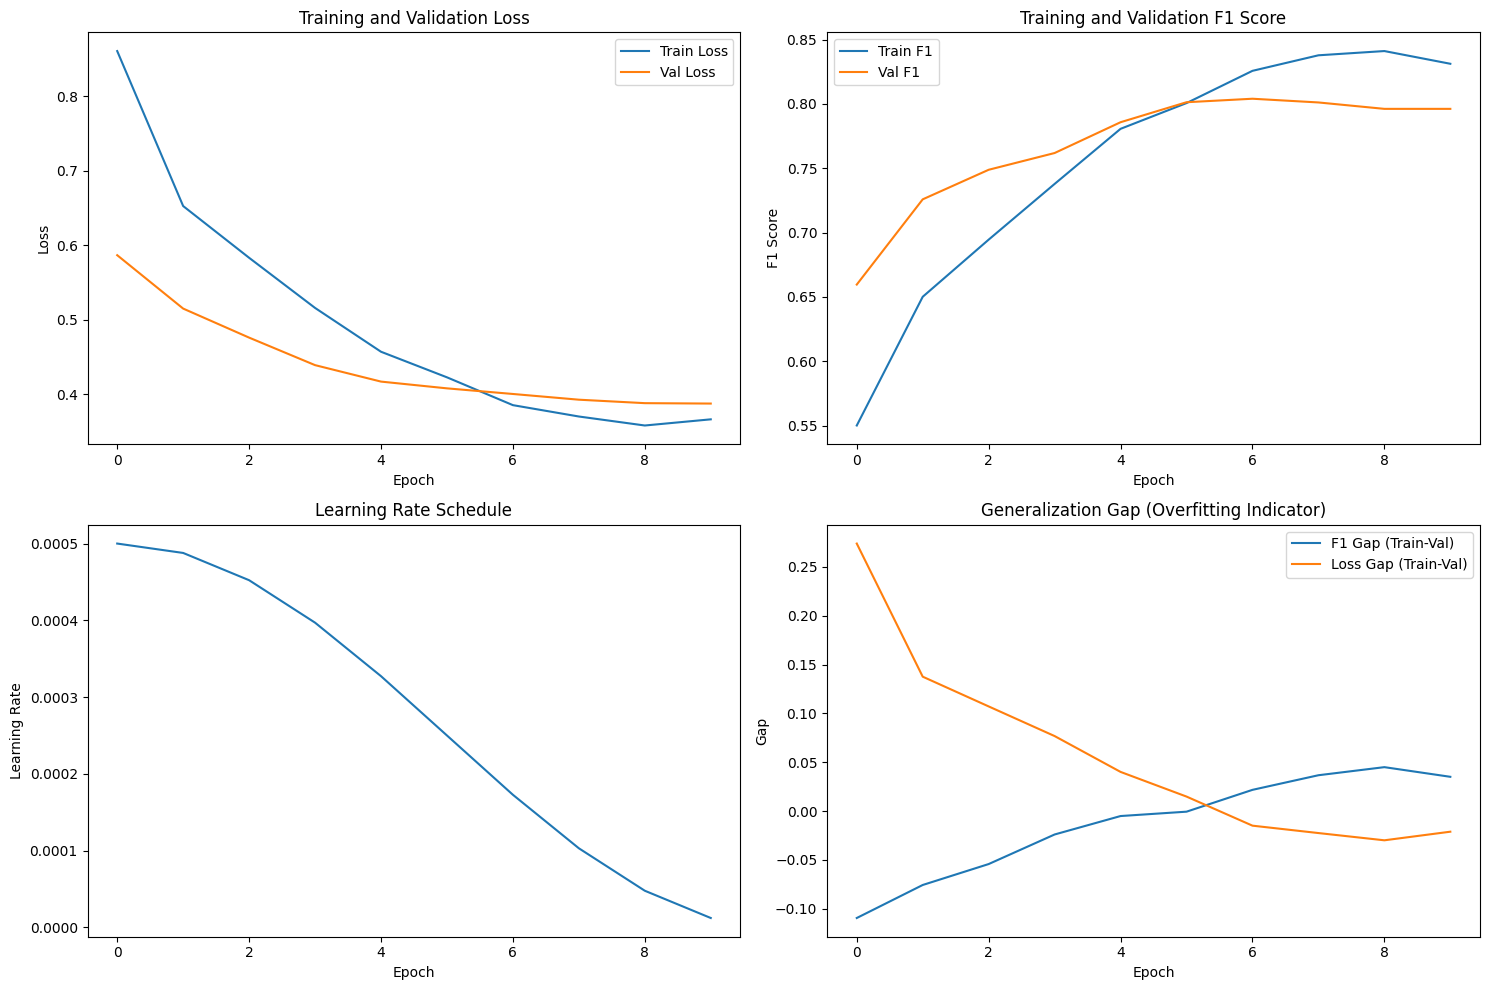


Saving final model...
Final model saved to: models/biobert_disease_ner_pytorch_improved\final_model.pt

Testing NER model with sample sentences:

Input: Patients with adenomatous polyposis coli may develop colon cancer.
Token		Tag
------------------------------
Patients		B-Disease
with		B-Disease
adenomatous		B-Disease
polyposis		I-Disease
coli		I-Disease
may		I-Disease
develop		I-Disease
colon		I-Disease
cancer.		B-Disease

Extracted Entities:
- Patients (Disease)
- with (Disease)
- adenomatous polyposis coli may develop colon (Disease)
- cancer. (Disease)

Input: BRCA1 mutations are associated with breast cancer risk.
Token		Tag
------------------------------
BRCA1		B-Disease
mutations		B-Disease
are		B-Disease
associated		B-Disease
with		B-Disease
breast		B-Disease
cancer		I-Disease
risk.		I-Disease

Extracted Entities:
- BRCA1 (Disease)
- mutations (Disease)
- are (Disease)
- associated (Disease)
- with (Disease)
- breast cancer risk. (Disease)

Input: Alzheimer's disease is a neu

In [15]:
# Cell 9: Train the NER Model with PyTorch - Enhanced with Regularization (10 epochs)

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from datasets import load_dataset
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report as sk_classification_report
import time
from datetime import timedelta

# --- Check device availability ---
print("Checking device availability...")
start_time = time.time()
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"GPU available: {torch.cuda.get_device_name(device)}")
    device = torch.device("cuda")
else:
    print("No GPU found, using CPU instead.")
    device = torch.device("cpu")

# --- Configuration ---
CORPUS_NAME = "ncbi_disease"
PREPARED_CORPUS_DIR = "corpus_data/prepared_ncbi_disease"
OUTPUT_MODEL_DIR = "models/biobert_disease_ner_pytorch_improved"
CATEGORY_MAPPINGS_PATH = os.path.join(PREPARED_CORPUS_DIR, "category_mappings.json")

# Training hyperparameters - with regularization improvements
LEARNING_RATE = 5e-4  # Reduced learning rate for better stability
BATCH_SIZE = 16 
EPOCHS = 10  # Increased to 10 epochs
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
MAX_SEQ_LENGTH = 128
TRAIN_SUBSET_SIZE = 1000
NUM_WORKERS = 0 
WEIGHT_DECAY = 1e-4  # L2 regularization
DROPOUT_RATE = 0.3  # Increased dropout for regularization
EARLY_STOPPING_PATIENCE = 3  # Stop if validation doesn't improve for this many epochs

# --- 1. Load data ---
print("Loading NCBI Disease dataset...")
try:
    raw_dataset = load_dataset(CORPUS_NAME, trust_remote_code=True)
    print(f"Dataset loaded: {raw_dataset}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit(1)

# --- 2. Load category mappings ---
print(f"Loading category mappings from {CATEGORY_MAPPINGS_PATH}...")
try:
    with open(CATEGORY_MAPPINGS_PATH, 'r') as f:
        category_mappings = json.load(f)
    
    category_list = category_mappings["category_list"]
    category_to_index = category_mappings["category_to_index"]
    index_to_category = {int(k): v for k, v in category_mappings["index_to_category"].items()}
    num_categories = len(category_list)
    
    print(f"Found {num_categories} categories: {category_list}")
except Exception as e:
    print(f"Error loading category mappings: {e}")
    # Fallback to default mapping
    category_list = ['O', 'B-Disease', 'I-Disease']
    category_to_index = {category: i for i, category in enumerate(category_list)}
    index_to_category = {i: category for i, category in enumerate(category_list)}
    num_categories = len(category_list)
    print(f"Using default categories: {category_list}")

# --- 3. Create a vocabulary from the dataset ---
print("\nBuilding vocabulary from training data...")
word_to_ix = {"<PAD>": 0, "<UNK>": 1}
max_seq_len = 0

# Process training data to build vocabulary
for example in tqdm(raw_dataset["train"], desc="Processing training data"):
    tokens = example["tokens"]
    max_seq_len = max(max_seq_len, len(tokens))
    for token in tokens:
        if token not in word_to_ix:
            word_to_ix[token] = len(word_to_ix)

# Cap sequence length for efficiency
max_seq_len = min(max_seq_len, MAX_SEQ_LENGTH)
print(f"Vocabulary size: {len(word_to_ix)}")
print(f"Maximum sequence length (capped): {max_seq_len}")

# --- 4. Custom collate function to handle variable length sequences ---
def collate_fn(batch):
    """
    Custom collate function that handles batches with variable length sequences.
    """
    # Sort batch by sequence length (descending)
    batch = sorted(batch, key=lambda x: len(x["original_tokens"]), reverse=True)
    
    # Get individual elements
    token_ids = [item["token_ids"] for item in batch]
    ner_tags = [item["ner_tags"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    original_tokens = [item["original_tokens"] for item in batch]
    
    # Pad sequences to the max length in this batch
    max_len = max(len(x) for x in token_ids)
    
    # Pad token_ids and ner_tags
    padded_token_ids = []
    padded_ner_tags = []
    padded_attention_masks = []
    
    for ids, tags, mask in zip(token_ids, ner_tags, attention_masks):
        # Calculate padding length
        padding_len = max_len - len(ids)
        
        # Pad
        padded_ids = torch.cat([ids, torch.zeros(padding_len, dtype=torch.long)])
        padded_tags = torch.cat([tags, torch.zeros(padding_len, dtype=torch.long)])
        padded_mask = torch.cat([mask, torch.zeros(padding_len, dtype=torch.float)])
        
        padded_token_ids.append(padded_ids)
        padded_ner_tags.append(padded_tags)
        padded_attention_masks.append(padded_mask)
    
    # Stack tensors
    token_ids_tensor = torch.stack(padded_token_ids)
    ner_tags_tensor = torch.stack(padded_ner_tags)
    attention_masks_tensor = torch.stack(padded_attention_masks)
    
    return {
        "token_ids": token_ids_tensor,
        "ner_tags": ner_tags_tensor,
        "attention_mask": attention_masks_tensor,
        "original_tokens": original_tokens
    }

# --- 5. Create PyTorch Dataset ---
class NERDataset(Dataset):
    def __init__(self, dataset, word_to_ix, max_length=128):
        self.dataset = dataset
        self.word_to_ix = word_to_ix
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        example = self.dataset[idx]
        tokens = example["tokens"]
        ner_tags = example["ner_tags"]
        
        # Truncate if too long
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
            ner_tags = ner_tags[:self.max_length]
        
        # Convert tokens to indices
        token_ids = [self.word_to_ix.get(token, self.word_to_ix["<UNK>"]) for token in tokens]
        
        return {
            "token_ids": torch.tensor(token_ids, dtype=torch.long),
            "ner_tags": torch.tensor(ner_tags, dtype=torch.long),
            "attention_mask": torch.tensor([1] * len(tokens), dtype=torch.float),
            "original_tokens": tokens
        }

# --- 6. Prepare datasets ---
print("\nPreparing datasets...")
# Limit training dataset size
train_subset = raw_dataset["train"].select(range(min(TRAIN_SUBSET_SIZE, len(raw_dataset["train"]))))
val_subset = raw_dataset["validation"].select(range(min(200, len(raw_dataset["validation"]))))

# Create test set for final evaluation
test_subset = raw_dataset["test"].select(range(min(200, len(raw_dataset["test"]))))

train_dataset = NERDataset(train_subset, word_to_ix, max_seq_len)
val_dataset = NERDataset(val_subset, word_to_ix, max_seq_len)
test_dataset = NERDataset(test_subset, word_to_ix, max_seq_len)

# Use custom collate function
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

print(f"Created data loaders with batch size {BATCH_SIZE}")

# --- 7. Create the BiLSTM model with improved regularization ---
class RegularizedBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, dropout=0.3):
        super(RegularizedBiLSTMModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        
        # Improved embedding with dropout
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embed_dropout = nn.Dropout(dropout)
        
        # Bidirectional LSTM with 2 layers and dropout between layers
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim // 2, 
            num_layers=2,  # Multiple layers for better feature extraction
            bidirectional=True, 
            batch_first=True,
            dropout=dropout  # Dropout between LSTM layers
        )
        
        # Layer normalization for regularization
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Multiple linear layers with dropout between them
        self.dropout1 = nn.Dropout(dropout)
        self.hidden2hidden = nn.Linear(hidden_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        
        # Initialize weights properly
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights for faster convergence and regularization"""
        # Xavier/Glorot initialization for linear layers
        nn.init.xavier_uniform_(self.hidden2hidden.weight)
        nn.init.xavier_uniform_(self.hidden2tag.weight)
        nn.init.zeros_(self.hidden2hidden.bias)
        nn.init.zeros_(self.hidden2tag.bias)
        
    def forward(self, sentence, attention_mask=None):
        # Embedding layer with dropout
        embeds = self.word_embeds(sentence)
        embeds = self.embed_dropout(embeds)
        
        # LSTM layer
        lstm_out, _ = self.lstm(embeds)
        
        # Layer normalization for more stable training
        lstm_out = self.layer_norm(lstm_out)
        
        # Apply attention mask
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1).expand_as(lstm_out)
            lstm_out = lstm_out * mask
        
        # Additional hidden layer with dropout
        lstm_out = self.dropout1(lstm_out)
        hidden = self.hidden2hidden(lstm_out)
        hidden = self.activation(hidden)
        hidden = self.dropout2(hidden)
        
        # Final linear layer
        tag_space = self.hidden2tag(hidden)
        return tag_space

# --- 8. Initialize the model ---
print("\nInitializing Regularized BiLSTM model...")
model = RegularizedBiLSTMModel(len(word_to_ix), category_to_index, EMBEDDING_DIM, HIDDEN_DIM, dropout=DROPOUT_RATE)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# --- 9. Define loss function and optimizer ---
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
# AdamW optimizer with weight decay for L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Cosine annealing scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- 10. Training and evaluation functions ---
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        token_ids = batch["token_ids"].to(device)
        ner_tags = batch["ner_tags"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        # Forward pass
        tag_scores = model(token_ids, attention_mask)
        
        # Reshape for loss calculation
        tag_scores = tag_scores.view(-1, model.tagset_size)
        ner_tags = ner_tags.view(-1)
        
        # Calculate loss
        loss = criterion(tag_scores, ner_tags)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        # For metric calculation
        preds = torch.argmax(tag_scores, dim=1).cpu().numpy()
        labels = ner_tags.cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels)
    
    # Calculate metrics (ignoring padded values)
    valid_indices = (np.array(all_labels) != 0)
    if valid_indices.sum() > 0:
        metrics = sk_classification_report(
            np.array(all_labels)[valid_indices], 
            np.array(all_preds)[valid_indices], 
            output_dict=True,
            zero_division=0
        )
        train_f1 = metrics.get('weighted avg', {}).get('f1-score', 0)
    else:
        train_f1 = 0
    
    return total_loss / len(dataloader), train_f1

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            token_ids = batch["token_ids"].to(device)
            ner_tags = batch["ner_tags"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            # Forward pass
            tag_scores = model(token_ids, attention_mask)
            
            # Reshape for loss calculation
            tag_scores = tag_scores.view(-1, model.tagset_size)
            ner_tags = ner_tags.view(-1)
            
            # Calculate loss
            loss = criterion(tag_scores, ner_tags)
            total_loss += loss.item()
            
            # For metric calculation
            preds = torch.argmax(tag_scores, dim=1).cpu().numpy()
            labels = ner_tags.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Calculate metrics (ignoring padded values)
    valid_indices = (np.array(all_labels) != 0)
    if valid_indices.sum() > 0:
        metrics = sk_classification_report(
            np.array(all_labels)[valid_indices], 
            np.array(all_preds)[valid_indices], 
            output_dict=True,
            zero_division=0
        )
        val_f1 = metrics.get('weighted avg', {}).get('f1-score', 0)
    else:
        val_f1 = 0
    
    return total_loss / len(dataloader), val_f1

# --- 11. Training loop with early stopping ---
print("\nStarting training...")
print(f"Using device: {device}")

model = model.to(device)

# History for plotting
history = {
    'train_loss': [],
    'val_loss': [],
    'train_f1': [],
    'val_f1': [],
    'learning_rates': []
}

best_val_f1 = 0
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model.pt")
final_model_path = os.path.join(OUTPUT_MODEL_DIR, "final_model.pt")
os.makedirs(OUTPUT_MODEL_DIR, exist_ok=True)

# Early stopping variables
early_stopping_counter = 0
early_stopping_best_f1 = 0

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Evaluate
    val_loss, val_f1 = evaluate(model, val_loader, criterion, device)
    
    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    history['learning_rates'].append(current_lr)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Epoch time: {timedelta(seconds=epoch_time)}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'model_state_dict': model.state_dict(),
            'word_to_ix': word_to_ix,
            'category_to_index': category_to_index,
            'index_to_category': index_to_category,
            'max_seq_len': max_seq_len,
            'embedding_dim': EMBEDDING_DIM,
            'hidden_dim': HIDDEN_DIM,
            'epoch': epoch + 1,
            'val_f1': val_f1
        }, best_model_path)
        print(f"Saved best model with val F1: {val_f1:.4f}")
        
        # Reset early stopping counter
        early_stopping_counter = 0
        early_stopping_best_f1 = val_f1
    else:
        # Increment early stopping counter
        early_stopping_counter += 1
        print(f"Validation F1 did not improve. Early stopping counter: {early_stopping_counter}/{EARLY_STOPPING_PATIENCE}")
        
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# --- 12. Evaluate on test set using best model ---
print("\nEvaluating best model on test set...")
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Evaluate on test set
test_loss, test_f1 = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

# --- 13. Plot training history ---
plt.figure(figsize=(15, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot F1 score
plt.subplot(2, 2, 2)
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')

# Plot learning rate
plt.subplot(2, 2, 3)
plt.plot(history['learning_rates'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Plot generalization gap (difference between train and val metrics)
plt.subplot(2, 2, 4)
f1_gaps = [t - v for t, v in zip(history['train_f1'], history['val_f1'])]
loss_gaps = [t - v for t, v in zip(history['train_loss'], history['val_loss'])]
plt.plot(f1_gaps, label='F1 Gap (Train-Val)')
plt.plot(loss_gaps, label='Loss Gap (Train-Val)')
plt.xlabel('Epoch')
plt.ylabel('Gap')
plt.legend()
plt.title('Generalization Gap (Overfitting Indicator)')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_MODEL_DIR, "training_history.png"))
plt.show()

# --- 14. Save final model ---
print("\nSaving final model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'word_to_ix': word_to_ix,
    'category_to_index': category_to_index,
    'index_to_category': index_to_category,
    'max_seq_len': max_seq_len,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'history': {k: [float(x) for x in v] for k, v in history.items()},
    'best_val_f1': float(best_val_f1),
    'test_f1': float(test_f1)
}, final_model_path)
print(f"Final model saved to: {final_model_path}")

# --- 15. Test the trained model ---
def predict_tags(model, text, word_to_ix, index_to_category, device):
    model.eval()
    tokens = text.split()
    token_ids = [word_to_ix.get(token, word_to_ix["<UNK>"]) for token in tokens]
    token_ids_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    attention_mask = torch.tensor([[1] * len(token_ids)], dtype=torch.float).to(device)
    
    with torch.no_grad():
        tag_scores = model(token_ids_tensor, attention_mask)
    
    _, predicted = torch.max(tag_scores, 2)
    predicted = predicted.squeeze(0).cpu().numpy()
    
    return [(tokens[i], index_to_category.get(tag, 'O')) for i, tag in enumerate(predicted)]

# Test with some sample sentences
print("\nTesting NER model with sample sentences:")
test_sentences = [
    "Patients with adenomatous polyposis coli may develop colon cancer.",
    "BRCA1 mutations are associated with breast cancer risk.",
    "Alzheimer's disease is a neurodegenerative disorder affecting memory.",
    "The study focused on multiple sclerosis and Parkinson's disease treatments.",
    "Diabetes mellitus type 2 is often associated with obesity."
]

for sentence in test_sentences:
    print(f"\nInput: {sentence}")
    results = predict_tags(model, sentence, word_to_ix, index_to_category, device)
    
    print("Token\t\tTag")
    print("-" * 30)
    for token, tag in results:
        print(f"{token}\t\t{tag}")
    
    # Extract disease entities
    entities = []
    current_entity = []
    current_type = None
    
    for token, tag in results:
        if tag.startswith('B-'):
            if current_entity:
                entities.append((' '.join(current_entity), current_type))
            current_entity = [token]
            current_type = tag[2:]  # Remove 'B-' prefix
        elif tag.startswith('I-') and current_entity and current_type == tag[2:]:
            current_entity.append(token)
        elif current_entity:
            entities.append((' '.join(current_entity), current_type))
            current_entity = []
            current_type = None
    
    if current_entity:
        entities.append((' '.join(current_entity), current_type))
    
    print("\nExtracted Entities:")
    if entities:
        for entity, ent_type in entities:
            print(f"- {entity} ({ent_type})")
    else:
        print("- No entities found")

# Calculate total training time
total_time = time.time() - start_time
print(f"\nTotal training time: {timedelta(seconds=total_time)}")
print(f"Best validation F1 score: {best_val_f1:.4f} (Epoch {checkpoint.get('epoch', 'unknown')})")
print(f"Test F1 score: {test_f1:.4f}")
print("\nTraining and testing completed successfully!")

In [ ]:
# Cell 10: NER Application - Interactive Disease Entity Recognition

In [18]:
# Cell 10: NER Application - Advanced Disease Entity Recognition

import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import re

# --- Configuration and Loading ---
MODEL_DIR = "models/biobert_disease_ner_pytorch_improved"
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.pt")
COLORS = {'Disease': '#8dd3c7'}
HTML_COLORS = {'Disease': '#8dd3c7'}
DEFAULT_TEXT = "Patients with adenomatous polyposis coli may develop colorectal cancer, while BRCA1 mutations increase breast cancer risk. Alzheimer's disease and Parkinson's disease are neurodegenerative disorders affecting cognition."

# --- Post-processing configuration ---
MIN_ENTITY_LENGTH = 2  # Minimum number of tokens for a valid disease entity
MAX_ENTITY_LENGTH = 8  # Maximum number of tokens for a reasonable disease entity

# Stopwords and common terms that should not be diseases by themselves
STOPWORDS = {"in", "the", "a", "an", "of", "with", "as", "and", "or", "but", "are", "is", "was", "were", "have", "been", "has", "to", "for", "on", "at", "by", "from", "about", "like", "through", "over", "before", "after", "between", "under", "during", "may", "can", "could", "would", "should", "will"}

# Non-disease terms commonly mislabeled by the model
NON_DISEASE_TERMS = {"patients", "individuals", "people", "persons", "subjects", "doctors", "researchers", "scientists", "clinicians", "develop", "increase", "decrease", "affect", "cause", "treat", "therapy", "medication", "drug", "diagnosed", "treatment"}

# Disease-specific boundary words (words that likely indicate the end of a disease entity)
DISEASE_BOUNDARY_WORDS = {"risk", "patients", "affects", "causes", "symptoms", "while", "develops", "increases", "study", "research", "treatment", "therapy", "diagnosis", "prognosis", "mortality", "morbidity"}

# Common linking words between disease entities that should trigger a split
LINKING_WORDS = {"and", "or", "as well as", "along with", "including", "such as", "like", "whereas", "while"}

CONFIDENCE_THRESHOLD = 0.8  # Default threshold for accepting entity predictions

# --- Load Model ---
def load_model_components():
    """Load model and required components"""
    if not os.path.exists(BEST_MODEL_PATH):
        print(f"Error: Model not found at {BEST_MODEL_PATH}")
        print("Please run the training cell first.")
        return None
    
    # Load checkpoint
    try:
        checkpoint = torch.load(BEST_MODEL_PATH, map_location=torch.device('cpu'))
        word_to_ix = checkpoint.get('word_to_ix')
        category_to_index = checkpoint.get('category_to_index')
        index_to_category = checkpoint.get('index_to_category')
        embedding_dim = checkpoint.get('embedding_dim', 200)
        hidden_dim = checkpoint.get('hidden_dim', 128)
        
        # Define the model class
        class RegularizedBiLSTMModel(torch.nn.Module):
            def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, dropout=0.3):
                super(RegularizedBiLSTMModel, self).__init__()
                self.embedding_dim = embedding_dim
                self.hidden_dim = hidden_dim
                self.vocab_size = vocab_size
                self.tag_to_ix = tag_to_ix
                self.tagset_size = len(tag_to_ix)
                
                # Improved embedding with dropout
                self.word_embeds = torch.nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
                self.embed_dropout = torch.nn.Dropout(dropout)
                
                # Bidirectional LSTM with 2 layers and dropout between layers
                self.lstm = torch.nn.LSTM(
                    embedding_dim, 
                    hidden_dim // 2, 
                    num_layers=2,
                    bidirectional=True, 
                    batch_first=True,
                    dropout=dropout
                )
                
                # Layer normalization for regularization
                self.layer_norm = torch.nn.LayerNorm(hidden_dim)
                
                # Multiple linear layers with dropout between them
                self.dropout1 = torch.nn.Dropout(dropout)
                self.hidden2hidden = torch.nn.Linear(hidden_dim, hidden_dim)
                self.activation = torch.nn.ReLU()
                self.dropout2 = torch.nn.Dropout(dropout)
                self.hidden2tag = torch.nn.Linear(hidden_dim, self.tagset_size)
                
            def forward(self, sentence, attention_mask=None):
                embeds = self.word_embeds(sentence)
                embeds = self.embed_dropout(embeds)
                
                lstm_out, _ = self.lstm(embeds)
                lstm_out = self.layer_norm(lstm_out)
                
                if attention_mask is not None:
                    mask = attention_mask.unsqueeze(-1).expand_as(lstm_out)
                    lstm_out = lstm_out * mask
                
                lstm_out = self.dropout1(lstm_out)
                hidden = self.hidden2hidden(lstm_out)
                hidden = self.activation(hidden)
                hidden = self.dropout2(hidden)
                
                tag_space = self.hidden2tag(hidden)
                return tag_space
        
        # Initialize the model
        model = RegularizedBiLSTMModel(
            len(word_to_ix), 
            category_to_index, 
            embedding_dim, 
            hidden_dim
        )
        
        # Load the state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()  # Set model to evaluation mode
        
        print(f"Model loaded successfully from {BEST_MODEL_PATH}")
        val_f1 = checkpoint.get('val_f1', 'N/A')
        if isinstance(val_f1, (int, float)):
            print(f"Validation F1 score: {val_f1:.4f}")
        else:
            print(f"Validation F1 score: {val_f1}")
        
        return {
            'model': model,
            'word_to_ix': word_to_ix,
            'category_to_index': category_to_index,
            'index_to_category': index_to_category,
        }
    
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# --- Prediction Function with Confidence Scores ---
def predict_tags_with_confidence(text, model_components):
    """Predict NER tags for input text with confidence scores"""
    if model_components is None:
        return []
    
    model = model_components['model']
    word_to_ix = model_components['word_to_ix']
    index_to_category = model_components['index_to_category']
    
    # Tokenize text
    tokens = text.split()
    
    # Convert tokens to indices, handling unknown tokens
    token_ids = [word_to_ix.get(token, word_to_ix["<UNK>"]) for token in tokens]
    
    # Create tensor
    token_ids_tensor = torch.tensor([token_ids], dtype=torch.long)
    attention_mask = torch.tensor([[1] * len(token_ids)], dtype=torch.float)
    
    # Get predictions with confidence scores
    with torch.no_grad():
        tag_scores = model(token_ids_tensor, attention_mask)
        # Apply softmax to get probabilities
        tag_probs = torch.nn.functional.softmax(tag_scores, dim=2)
    
    # Get predicted tags and confidence scores
    predicted_probs, predicted_indices = torch.max(tag_probs, dim=2)
    predicted_indices = predicted_indices.squeeze(0).cpu().numpy()
    predicted_probs = predicted_probs.squeeze(0).cpu().numpy()
    
    # Convert to tag names
    predicted_tags = [index_to_category.get(idx, 'O') for idx in predicted_indices]
    
    # Combine tokens, tags, and confidence scores
    return list(zip(tokens, predicted_tags, predicted_probs))

# --- Advanced Entity Extraction ---
def extract_entities_advanced(tagged_tokens, original_text=None):
    """Extract entities with advanced post-processing rules"""
    # Step 1: Extract raw entities as before
    raw_entities = []
    current_entity = []
    current_indices = []
    current_tag = None
    current_confidence_sum = 0
    
    for i, (token, tag, confidence) in enumerate(tagged_tokens):
        if tag.startswith('B-'):
            # Complete the previous entity if any
            if current_entity:
                raw_entities.append({
                    'text': ' '.join(current_entity),
                    'type': current_tag,
                    'indices': current_indices,
                    'confidence': current_confidence_sum / len(current_entity)
                })
                current_entity = []
                current_indices = []
            
            # Start new entity
            current_entity.append(token)
            current_indices.append(i)
            current_tag = tag[2:]  # Remove 'B-' prefix
            current_confidence_sum = confidence
            
        elif tag.startswith('I-') and current_entity and tag[2:] == current_tag:
            # Continue the current entity
            current_entity.append(token)
            current_indices.append(i)
            current_confidence_sum += confidence
            
        else:
            # Complete the previous entity if any
            if current_entity:
                raw_entities.append({
                    'text': ' '.join(current_entity),
                    'type': current_tag,
                    'indices': current_indices,
                    'confidence': current_confidence_sum / len(current_entity)
                })
                current_entity = []
                current_indices = []
                current_tag = None
            
    # Add the last entity if any
    if current_entity:
        raw_entities.append({
            'text': ' '.join(current_entity),
            'type': current_tag,
            'indices': current_indices,
            'confidence': current_confidence_sum / len(current_entity)
        })
    
    # Step 2: Apply advanced post-processing
    processed_entities = []
    
    for entity in raw_entities:
        # Skip entities with confidence below threshold
        if entity['confidence'] < CONFIDENCE_THRESHOLD:
            continue
            
        # Skip single-token entities that are in our exclusion lists
        if len(entity['indices']) == 1:
            token = entity['text'].lower()
            if token in STOPWORDS or token in NON_DISEASE_TERMS:
                continue
                
        # Skip entities that are too long (likely false positives)
        if len(entity['indices']) > MAX_ENTITY_LENGTH:
            # Try to split long entities into smaller ones
            split_entities = split_long_entity(entity, tagged_tokens)
            processed_entities.extend(split_entities)
            continue
            
        # Skip entities that are too short but not in our allow list
        if len(entity['indices']) < MIN_ENTITY_LENGTH:
            # If it's a single token, check if it looks like a disease name
            if len(entity['indices']) == 1:
                token = entity['text'].lower()
                # Allow capitals (potential acronyms) or long words
                if not (token[0].isupper() or len(token) > 7):
                    continue
        
        # Apply boundary correction
        corrected_entity = correct_entity_boundaries(entity, tagged_tokens)
        processed_entities.append(corrected_entity)
    
    # Step 3: Split entities with conjunction markers
    split_entities = []
    for entity in processed_entities:
        parts = split_entity_by_conjunctions(entity, tagged_tokens)
        split_entities.extend(parts)
    
    # Step 4: Final filtering and consolidation
    final_entities = filter_and_consolidate_entities(split_entities, tagged_tokens)
    
    # Sort entities by their position in text
    final_entities.sort(key=lambda e: e['indices'][0])
    
    return final_entities

def split_long_entity(entity, tagged_tokens):
    """Split a long entity at logical boundaries like periods or conjunctions"""
    result = []
    
    # Get the full entity text and indices
    entity_indices = entity['indices']
    entity_tokens = [tagged_tokens[idx][0] for idx in entity_indices]
    entity_type = entity['type']
    
    # Find potential split points
    split_points = []
    for i, idx in enumerate(entity_indices):
        token = entity_tokens[i].lower()
        
        # Check for sentence boundaries (periods)
        if token.endswith('.') or token.endswith('?') or token.endswith('!'):
            split_points.append(i)
            
        # Check for conjunctions and linking words
        if token in LINKING_WORDS:
            split_points.append(i)
            
        # Check for common boundary markers
        if token in DISEASE_BOUNDARY_WORDS:
            split_points.append(i)
    
    # If no split points, try to find chunks of reasonable size
    if not split_points and len(entity_indices) > MAX_ENTITY_LENGTH:
        # Try to break at every ~5 tokens
        for i in range(MIN_ENTITY_LENGTH, len(entity_indices), 5):
            split_points.append(i)
    
    # If split points found, create sub-entities
    if split_points:
        start_idx = 0
        for split_idx in split_points:
            if split_idx - start_idx >= MIN_ENTITY_LENGTH:
                # Create a new entity from this segment
                segment_indices = entity_indices[start_idx:split_idx+1]
                segment_text = ' '.join([tagged_tokens[idx][0] for idx in segment_indices])
                avg_confidence = sum(tagged_tokens[idx][2] for idx in segment_indices) / len(segment_indices)
                
                result.append({
                    'text': segment_text,
                    'type': entity_type,
                    'indices': segment_indices,
                    'confidence': avg_confidence
                })
            start_idx = split_idx + 1
        
        # Add the last segment if it has enough tokens
        if len(entity_indices) - start_idx >= MIN_ENTITY_LENGTH:
            segment_indices = entity_indices[start_idx:]
            segment_text = ' '.join([tagged_tokens[idx][0] for idx in segment_indices])
            avg_confidence = sum(tagged_tokens[idx][2] for idx in segment_indices) / len(segment_indices)
            
            result.append({
                'text': segment_text,
                'type': entity_type,
                'indices': segment_indices,
                'confidence': avg_confidence
            })
    else:
        # If couldn't split logically, return the original entity
        result.append(entity)
            
    return result

def correct_entity_boundaries(entity, tagged_tokens):
    """Adjust entity boundaries to be more accurate"""
    indices = entity['indices']
    
    # If entity ends with a boundary word, trim it
    if len(indices) > MIN_ENTITY_LENGTH:
        last_token = tagged_tokens[indices[-1]][0].lower()
        if last_token in DISEASE_BOUNDARY_WORDS or last_token in ["may", "can", "could", "will", "develop", "cause"]:
            indices = indices[:-1]
            
    # If entity starts with a non-disease term, trim it
    if len(indices) > MIN_ENTITY_LENGTH:
        first_token = tagged_tokens[indices[0]][0].lower()
        if first_token in NON_DISEASE_TERMS:
            indices = indices[1:]
    
    # Recalculate confidence and text after boundary adjustments
    if indices != entity['indices']:
        text = ' '.join([tagged_tokens[idx][0] for idx in indices])
        confidence = sum(tagged_tokens[idx][2] for idx in indices) / len(indices)
        
        return {
            'text': text,
            'type': entity['type'],
            'indices': indices,
            'confidence': confidence
        }
    
    return entity

def split_entity_by_conjunctions(entity, tagged_tokens):
    """Split an entity if it contains conjunctions connecting multiple diseases"""
    indices = entity['indices']
    tokens = [tagged_tokens[idx][0].lower() for idx in indices]
    entity_type = entity['type']
    
    # Look for conjunction patterns
    conjunction_positions = []
    for i, token in enumerate(tokens):
        if token in LINKING_WORDS:
            # Check if there's a reasonable entity on both sides
            if i >= MIN_ENTITY_LENGTH and (len(tokens) - i - 1) >= MIN_ENTITY_LENGTH:
                conjunction_positions.append(i)
    
    # Also look for disease terms that likely indicate entity boundaries
    disease_keywords = ["disease", "syndrome", "disorder", "cancer", "tumor", "infection"]
    for i, token in enumerate(tokens):
        if i > 0 and i < len(tokens) - 1:
            if token in disease_keywords:
                # Check if the next token is a potential conjunction
                if tokens[i+1] in LINKING_WORDS or tokens[i+1] in ["and", "or"]:
                    conjunction_positions.append(i+1)
    
    # If no conjunctions found, return the original entity
    if not conjunction_positions:
        return [entity]
    
    # Split the entity at conjunction positions
    result = []
    start_idx = 0
    
    for pos in conjunction_positions:
        if pos - start_idx >= MIN_ENTITY_LENGTH:
            # Create first part entity
            part_indices = indices[start_idx:pos]
            part_text = ' '.join([tagged_tokens[idx][0] for idx in part_indices])
            part_confidence = sum(tagged_tokens[idx][2] for idx in part_indices) / len(part_indices)
            
            result.append({
                'text': part_text,
                'type': entity_type,
                'indices': part_indices,
                'confidence': part_confidence
            })
        
        # Skip the conjunction
        start_idx = pos + 1
    
    # Add the final part if it's long enough
    if len(indices) - start_idx >= MIN_ENTITY_LENGTH:
        part_indices = indices[start_idx:]
        part_text = ' '.join([tagged_tokens[idx][0] for idx in part_indices])
        part_confidence = sum(tagged_tokens[idx][2] for idx in part_indices) / len(part_indices)
        
        result.append({
            'text': part_text,
            'type': entity_type,
            'indices': part_indices,
            'confidence': part_confidence
        })
    
    return result if result else [entity]

def filter_and_consolidate_entities(entities, tagged_tokens):
    """Final filtering and consolidation of entities"""
    if not entities:
        return []
    
    # Sort entities by position
    sorted_entities = sorted(entities, key=lambda e: e['indices'][0])
    
    # Filter out entities that are substrings of other entities with higher confidence
    filtered = []
    for i, entity in enumerate(sorted_entities):
        is_substring = False
        for j, other in enumerate(sorted_entities):
            if i != j and set(entity['indices']).issubset(set(other['indices'])):
                if other['confidence'] >= entity['confidence']:
                    is_substring = True
                    break
        
        if not is_substring:
            filtered.append(entity)
    
    # Final check: remove entities that contain only common words and no disease-specific terms
    disease_indicators = ["disease", "syndrome", "disorder", "cancer", "tumor", "infection", "itis", "oma", "pathy", "sis", "plasia"]
    
    result = []
    for entity in filtered:
        # Check if the entity contains any disease indicators
        text = entity['text'].lower()
        
        has_indicator = any(indicator in text for indicator in disease_indicators)
        is_capitalized = any(token[0].isupper() for token in text.split() if len(token) > 1)
        
        # Keep entities that have disease indicators or capitalized terms (potential proper names)
        if has_indicator or is_capitalized:
            result.append(entity)
        # For others, only keep if confidence is very high
        elif entity['confidence'] > 0.95:
            result.append(entity)
    
    return result

# --- Visualization Functions ---
def highlight_text_html(text, entities):
    """Create HTML with highlighted entities"""
    if not entities:
        return f"<p>{text}</p>"
    
    tokens = text.split()
    highlighted_tokens = tokens.copy()
    
    # Sort entities by their first index in reverse order (to avoid index shifting)
    sorted_entities = sorted(entities, key=lambda e: e['indices'][0], reverse=True)
    
    for entity in sorted_entities:
        indices = entity['indices']
        entity_type = entity['type']
        confidence = entity.get('confidence', 1.0)
        color = HTML_COLORS.get(entity_type, '#cccccc')
        
        # Get the tokens for this entity
        if indices:
            # If it's a single token entity
            if len(indices) == 1:
                highlighted_tokens[indices[0]] = f'<mark style="background-color: {color}; border-radius: 3px; padding: 1px 3px;" title="Confidence: {confidence:.2f}">{tokens[indices[0]]}</mark>'
            else:
                # Replace the first token with styled opening
                highlighted_tokens[indices[0]] = f'<mark style="background-color: {color}; border-radius: 3px; padding: 1px 3px;" title="Confidence: {confidence:.2f}">{tokens[indices[0]]}'
                
                # Replace the last token with styled closing
                highlighted_tokens[indices[-1]] = f'{tokens[indices[-1]]}</mark>'
    
    return f"<p style='font-size: 16px; line-height: 1.6;'>{' '.join(highlighted_tokens)}</p>"

def visualize_entity_attention(text, tagged_tokens, entities):
    """Visualize entity attention using a heatmap"""
    if not tagged_tokens:
        return
    
    tokens = [pair[0] for pair in tagged_tokens]
    tags = [pair[1] for pair in tagged_tokens]
    
    # Create a numerical representation for tags (0 for 'O', 1 for 'B-', 0.5 for 'I-')
    tag_values = []
    for tag in tags:
        if tag.startswith('B-'):
            tag_values.append(1.0)
        elif tag.startswith('I-'):
            tag_values.append(0.5)
        else:
            tag_values.append(0.0)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 3))
    
    # Plot heatmap
    tag_array = np.array([tag_values])
    cmap = LinearSegmentedColormap.from_list('entity_map', ['white', '#f781bf'])
    heatmap = ax.imshow(tag_array, cmap=cmap, aspect='auto')
    
    # Set ticks and labels
    ax.set_yticks([])
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    
    # Add entity boxes
    for entity in entities:
        indices = entity['indices']
        if indices:
            # Create a rectangle for each entity
            rect = patches.Rectangle(
                (indices[0] - 0.5, -0.5), 
                len(indices), 
                1, 
                linewidth=2, 
                edgecolor=COLORS.get(entity['type'], '#cccccc'),
                facecolor='none'
            )
            ax.add_patch(rect)
    
    plt.title('Entity Detection Visualization')
    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(entities):
    """Plot histogram of entity confidence scores"""
    if not entities:
        return
    
    confidences = [entity.get('confidence', 0) for entity in entities]
    
    plt.figure(figsize=(8, 4))
    plt.hist(confidences, bins=10, color='#8dd3c7', edgecolor='black', alpha=0.7)
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Entities')
    plt.title('Entity Detection Confidence Distribution')
    plt.axvline(x=CONFIDENCE_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({CONFIDENCE_THRESHOLD})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Interactive Application ---
def create_ner_app():
    """Create an interactive NER application"""
    model_components = load_model_components()
    
    if model_components is None:
        print("Cannot create application without a model.")
        return
    
    # Create widgets
    text_area = widgets.Textarea(
        value=DEFAULT_TEXT,
        placeholder='Enter text to analyze',
        description='Text:',
        layout={'width': '90%', 'height': '100px'},
        disabled=False
    )
    
    analyze_button = widgets.Button(
        description='Analyze',
        button_style='primary',
        tooltip='Click to analyze the text',
        icon='search'
    )
    
    confidence_slider = widgets.FloatSlider(
        value=CONFIDENCE_THRESHOLD,
        min=0.0,
        max=1.0,
        step=0.05,
        description='Confidence:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )
    
    output_area = widgets.Output()
    
    # Define analyze function
    def on_analyze_button_clicked(b):
        with output_area:
            clear_output()
            
            input_text = text_area.value
            if not input_text.strip():
                print("Please enter some text to analyze.")
                return
            
            # Update threshold from slider
            global CONFIDENCE_THRESHOLD
            CONFIDENCE_THRESHOLD = confidence_slider.value
            
            # Predict tags with confidence
            tagged_tokens = predict_tags_with_confidence(input_text, model_components)
            
            # Extract entities with advanced post-processing
            entities = extract_entities_advanced(tagged_tokens, input_text)
            
            # Display highlighted text
            display(HTML("<h3>Identified Entities:</h3>"))
            display(HTML(highlight_text_html(input_text, entities)))
            
            # Display entity list
            if entities:
                display(HTML("<h3>Entity List:</h3>"))
                for i, entity in enumerate(entities, 1):
                    confidence = entity.get('confidence', 0)
                    confidence_str = f" (Confidence: {confidence:.2f})"
                    display(HTML(f"<p><b>{i}.</b> <span style='background-color: {HTML_COLORS.get(entity['type'], '#cccccc')}; padding: 2px 5px; border-radius: 3px;'>{entity['text']}</span> <i>({entity['type']}{confidence_str})</i></p>"))
            else:
                display(HTML("<p>No entities found.</p>"))
            
            # Visualizations
            if entities:
                display(HTML("<h3>Visualizations:</h3>"))
                visualize_entity_attention(input_text, tagged_tokens, entities)
                plot_confidence_distribution(entities)
    
    # Add event handlers
    analyze_button.on_click(on_analyze_button_clicked)
    confidence_slider.observe(lambda change: on_analyze_button_clicked(None), names='value')
    
    # Create layout
    app_layout = widgets.VBox([
        widgets.HTML("<h2>Disease Entity Recognition</h2>"),
        widgets.HTML("<p>Enter biomedical text and click 'Analyze' to identify disease entities.</p>"),
        text_area,
        widgets.HBox([analyze_button, confidence_slider]),
        output_area
    ])
    
    # Display the app
    display(app_layout)
    
    # Analyze initial text
    on_analyze_button_clicked(None)

# --- Main Execution ---
# Create the NER application
create_ner_app()

Model loaded successfully from models/biobert_disease_ner_pytorch_improved\best_model.pt
Validation F1 score: 0.8040
